# ReCovNet: Deep Reinforcement Learning for Solving MBCLP

## Prepare: Install dependencies
### Install with pip
* python=3.7
* PyTorch>=1.1
* numpy
* tqdm
* cv2
* tensorboard_logger

In [1]:
from utils import torch_load_cpu, load_problem, get_inner_model, move_to
from nets.attention_model import AttentionModel
from tensorboard_logger import Logger as TbLogger
import torch

## load the settings

In [2]:
# load the run args
%run options

# Set the random seed
torch.manual_seed(1234)

# Optionally configure tensorboard
tb_logger = None
if not opts.no_tensorboard:
    tb_logger = TbLogger(os.path.join(opts.log_dir, "{}_{}".format(opts.problem, opts.n_users, opts.n_facilities), opts.run_name))

# Set the device
use_cuda=True
opts.device = torch.device("cuda" if use_cuda else "cpu")
opts

Namespace(baseline=None, batch_size=640, bl_alpha=0.05, bl_warmup_epochs=0, checkpoint_encoder=False, checkpoint_epochs=1, data_distribution=None, device=device(type='cuda'), embedding_dim=128, epoch_size=128000, epoch_start=0, eval_batch_size=1000, eval_only=False, exp_beta=0.8, hidden_dim=128, load_path=None, log_dir='logs', log_step=50, lr_critic=0.0001, lr_decay=1, lr_model=0.0001, max_grad_norm=1.0, model='attention', n_encode_layers=3, n_epochs=500, n_facilities=100, n_users=1109, no_cuda=False, no_progress_bar=False, no_tensorboard=False, normalization='batch', output_dir='outputs', p=20, problem='MCLP', r=None, resume=None, run_name='100_20_20231020T145830', save_dir='outputs\\MCLP\\100_20_20231020T145830', seed=2023, shrink_size=None, tanh_clipping=10.0, use_cuda=True, val_dataset=None, val_size=2000)

## Figure out what's the problem

In [3]:
problem = load_problem(opts.problem)
problem

problems.MCLP.problem_MCLP.MCLP

## Initialize our policy network

In [4]:
model_class = {
    # 'pointer': PointerNetwork,
    'attention': AttentionModel
}.get(opts.model, None)

assert model_class is not None, "Unknown model: {}".format(model_class)
model = model_class(
    opts.embedding_dim,
    opts.hidden_dim,
    problem,
    n_encode_layers=opts.n_encode_layers,
    mask_inner=True,
    mask_logits=True,
    normalization=opts.normalization,
    tanh_clipping=opts.tanh_clipping,
    checkpoint_encoder=opts.checkpoint_encoder,
    shrink_size=opts.shrink_size,
    dy=False
).to(opts.device)

model

AttentionModel(
  (init_embed): Linear(in_features=2, out_features=128, bias=True)
  (init_dynamic): Linear(in_features=1, out_features=32, bias=True)
  (l2_dynamic): Linear(in_features=32, out_features=64, bias=True)
  (l3_dynamic): Linear(in_features=64, out_features=128, bias=True)
  (embedder): GraphAttentionEncoder(
    (layers): Sequential(
      (0): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention()
        )
        (1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): SkipConnection(
          (module): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
          )
        )
        (3): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
  

## load the trained model

In [5]:
opts.load_path = './model/real/epoch-450.pt'
# load model from load_path
assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    print('  [*] Loading the trained model from {}'.format(load_path))
    load_data = torch_load_cpu(load_path)

# Overwrite model parameters by parameters to load q
model_ = get_inner_model(model)
model.load_state_dict({**model_.state_dict(), **load_data.get('model', {})})

  [*] Loading the trained model from ./model/real/epoch-450.pt


<All keys matched successfully>

## Load the real-world datasets

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
road_net = gpd.read_file("./data/beijing/chaoyang_pro.shp")
road_net.head(3)

,name,type,oneway,bridge,tunnel,city,province,X,geometry
0,慧忠路,城市次干道,是,否,否,北京市,北京市,0.0,"LINESTRING (961352.924 4442947.246, 961371.635..."
1,None,城市支路,否,否,否,北京市,北京市,0.0,"LINESTRING (961576.716 4442949.777, 961581.935..."
2,北四环中路,城市快速路,是,否,否,北京市,北京市,0.0,"LINESTRING (958939.391 4441974.277, 958962.436..."


In [8]:
poi = gpd.read_file("./data/poi/emergency_cy.shp")
poi['POINT_X'] = poi['X']
poi['POINT_Y'] = poi['Y']
# poi['speed_pct_freeflow_rev']=1
print("The number of records is ", len(poi))

The number of records is  132


(955230.2199318785, 983314.839218135, 4421011.349599884, 4458191.154659854)

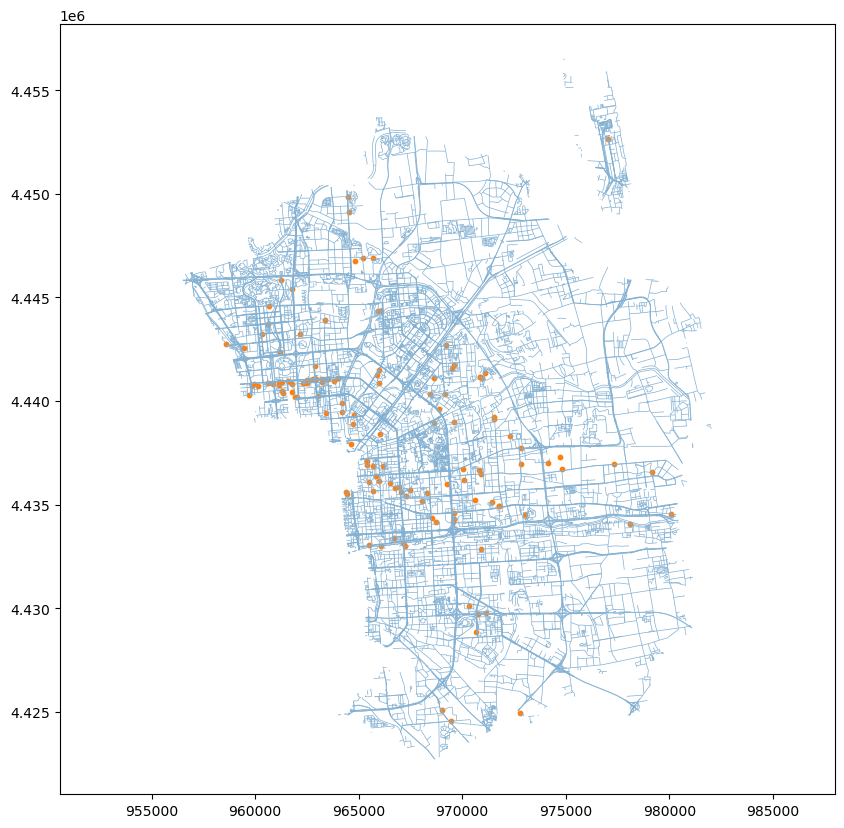

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
road_net.plot(ax=ax, color='#82b0d2', edgecolor='gray', linewidth=0.5)
ax.scatter(poi['X'], poi['Y'], c='C1', s=10, label = 'Emergency Location')
ax.axis('equal')

In [10]:
import numpy as np
def Normalization(x, y):
    max_x, max_y = np.max(x), np.max(y)
    min_x, min_y = np.min(x), np.min(y)
    S_x = (max_x-min_x)
    S_y = (max_y-min_y)
    S = max(S_x, S_y)
    new_x, new_y = (x-min_x)/S, (y-min_y)/S
    data_xy = np.vstack((new_x, new_y))
    Data = data_xy.T
    return new_x, new_y, S

In [11]:
poi_X = np.array(poi['POINT_X'])
poi_Y = np.array(poi['POINT_Y'])
norm_x, norm_y, S = Normalization(poi_X, poi_Y)
poi['NORM_X'] = norm_x
poi['NORM_Y'] = norm_y

In [12]:
def gen_real_data(ls, num_sample):
    real_datasets = []
    for i in range(num_sample):
        real_data = {}
        real_data["loc"] = torch.tensor(np.array(ls[['NORM_X', 'NORM_Y']])).to(torch.float32)
        real_data["facilities"] = torch.tensor(np.array(ls[['NORM_X', 'NORM_Y']])).to(torch.float32)
        real_data["p"] = 20
        real_data["r"] = 2000/S
        real_datasets.append(real_data)
    return real_datasets
#%%
num_sample = 1
opts.eval_batch_size = 10
opts.max_calc_batch_size = 1280000
width = 1280
real_datasets = gen_real_data(poi, num_sample)

In [13]:
from torch.utils.data import DataLoader
from tqdm import tqdm
opts.decode_strategy = 'sampling'
model.eval()
model.set_decode_type(
    "greedy" if opts.decode_strategy in ('bs', 'greedy') else "sampling")
dataloader = DataLoader(real_datasets, batch_size=opts.eval_batch_size)

In [14]:
def get_best(sequences, cost, ids=None, batch_size=None):
    """
    Ids contains [0, 0, 0, 1, 1, 2, ..., n, n, n] if 3 solutions found for 0th instance, 2 for 1st, etc
    :param sequences:
    :param lengths:
    :param ids:
    :return: list with n sequences and list with n lengths of solutions
    """
    if ids is None:
        idx = cost.argmin()
        return sequences[idx:idx+1, ...], cost[idx:idx+1, ...]

    splits = np.hstack([0, np.where(ids[:-1] != ids[1:])[0] + 1])
    mincosts = np.minimum.reduceat(cost, splits)

    group_lengths = np.diff(np.hstack([splits, len(ids)]))
    all_argmin = np.flatnonzero(np.repeat(mincosts, group_lengths) == cost)
    result = np.full(len(group_lengths) if batch_size is None else batch_size, -1, dtype=int)

    result[ids[all_argmin[::-1]]] = all_argmin[::-1]

    return [sequences[i] if i >= 0 else None for i in result], [cost[i] if i >= 0 else math.inf for i in result]

In [15]:
start = time.time()
results = []
for batch in tqdm(dataloader, disable=True):
    batch = move_to(batch, opts.device)
    start = time.time()
    with torch.no_grad():
        if opts.decode_strategy in ('sampling', 'greedy'):
            if opts.decode_strategy == 'greedy':
                assert width == 0, "Do not set width when using greedy"
                assert opts.eval_batch_size <= opts.max_calc_batch_size, \
                    "eval_batch_size should be smaller than calc batch size"
                batch_rep = 1
                iter_rep = 1
            elif width * opts.eval_batch_size > opts.max_calc_batch_size:
                assert opts.eval_batch_size == 1
                assert width % opts.max_calc_batch_size == 0
                batch_rep = opts.max_calc_batch_size
                iter_rep = width // opts.max_calc_batch_size
            else:
                batch_rep = width
                iter_rep = 1
            assert batch_rep > 0
            # This returns (batch_size, iter_rep shape)

            sequences, costs = model.sample_many(batch, batch_rep=batch_rep, iter_rep=iter_rep)
            batch_size = len(costs)
            ids = torch.arange(batch_size, dtype=torch.int64, device=costs.device)
            if sequences is None:
                sequences = [None] * batch_size
                costs = [math.inf] * batch_size
            else:
                sequences, costs = get_best(
                    sequences.cpu().numpy(), costs.cpu().numpy(),
                    ids.cpu().numpy() if ids is not None else None,
                    batch_size
                )
            duration = time.time() - start
            for seq, cost in zip(sequences, costs):
                seq = seq.tolist()
                results.append((cost, seq, duration))
costs, tours, durations = zip(*results)
print(f"The objective of MCBLP by DRL is: {-costs[0]}")
end = time.time()-start 
print(f"The running time of DRL is: {end}")

The objective of MCBLP by DRL is: 127.0
The running time of DRL is: 0.2720952033996582


In [16]:
def plot_result(ls, opt_sites, radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(12, 12))
    road_net.plot(ax=ax, color='#82b0d2', edgecolor='gray', linewidth=0.5)
    # ls.plot(ax=ax, column=ls['speed_pct_freeflow_rev'], k=5, markersize=5, cmap='Blues', label='Demand Points')
    legend_plot_flag = {'current': False, 'selected': False}
    ax.scatter(ls['POINT_X'], ls['POINT_Y'], c='#fa7f6f', s=20, label = 'Billboards')

    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:  #ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=10, label='Current Billboards')
                circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='red', fill=False, lw=2)

            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='b', marker='+', s=10,
                           label='Optimized Selected Billboards')
                circlelabel = 'Service Range for Optimized Selected Billboards'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='b', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='#8983bf', fill=False, lw=2)
            ax.add_artist(circle)
    #
    ax.axis('equal')
    return ax

<AxesSubplot:>

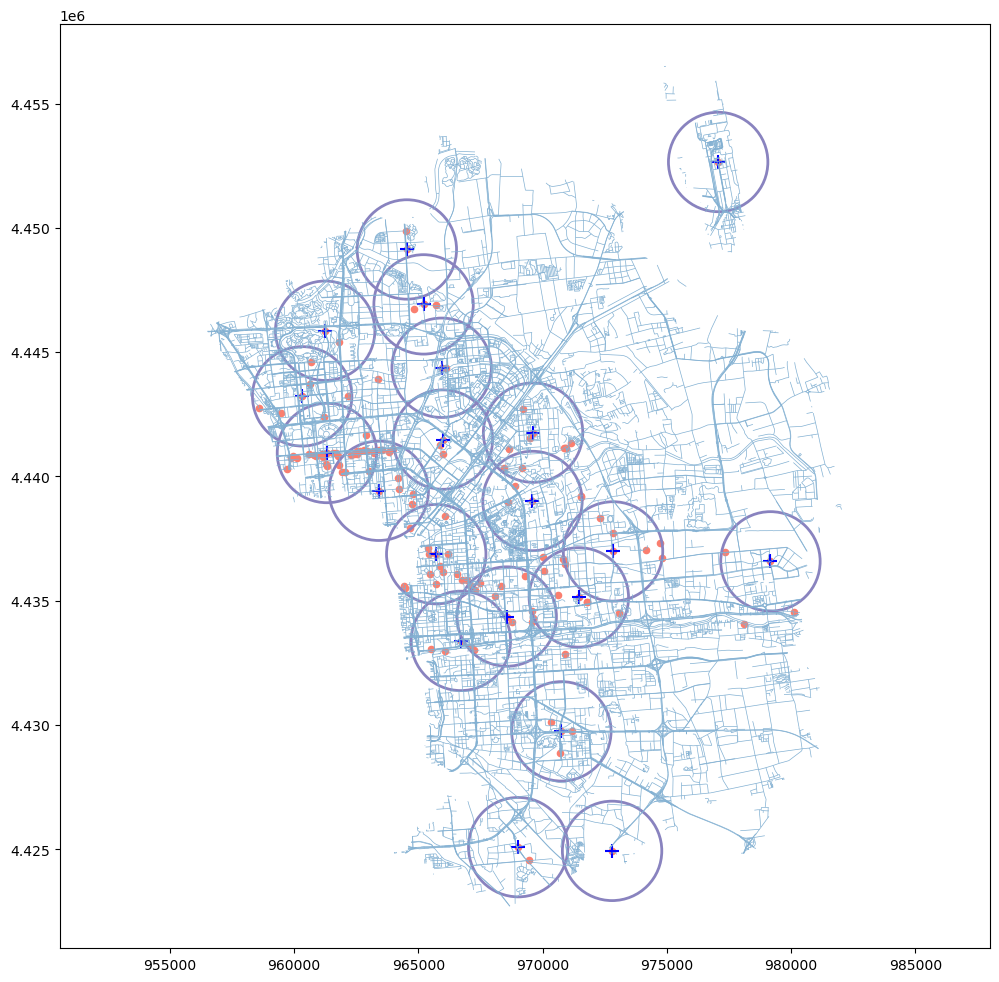

In [17]:
opt_sites = poi.iloc[tours]
plot_result(poi,opt_sites,2000)